# Heart Disease ML Pipeline (Kaggle)

End-to-end notebook to download the Kaggle heart disease dataset, preprocess with categorical encoding, train Logistic Regression and Decision Tree models, evaluate, and export joblib artifacts for a FastAPI service.

## 1) Set Up Environment and Dependencies

- Ensure KAGGLE_USERNAME and KAGGLE_KEY are set in the environment before running download cells.
- Uses dataset fedesoriano/heart-failure-prediction (classification).
- Outputs saved to ../models/ relative to this notebook.

In [2]:
import os
import json
import logging
from pathlib import Path
from typing import Tuple, Dict

import numpy as np
import pandas as pd
import joblib
from kaggle.api.kaggle_api_extended import KaggleApi
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    classification_report,
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

logging.basicConfig(level=logging.INFO, format="%(asctime)s [%(levelname)s] %(message)s")
LOGGER = logging.getLogger(__name__)

DATASET_SLUG = "fedesoriano/heart-failure-prediction"
RAW_DATA_PATH = Path("../data/heart.csv")
MODELS_DIR = Path("../models")
MODELS_DIR.mkdir(parents=True, exist_ok=True)

print("Working directory:", Path.cwd())
print("Models directory:", MODELS_DIR.resolve())
print("Kaggle username set:", bool(os.getenv("KAGGLE_USERNAME")))
print("Kaggle key set:", bool(os.getenv("KAGGLE_KEY")))

Working directory: /home/ashe/Documents/ml-lab/notebooks
Models directory: /home/ashe/Documents/ml-lab/models
Kaggle username set: True
Kaggle key set: True


## 2) Define Project Structure in Notebook

Create minimal folders we need for artifacts and note expected files.

In [3]:
for path in [Path("../data"), MODELS_DIR]:
    path.mkdir(parents=True, exist_ok=True)
    print("Ensured directory:", path.resolve())

print("Planned artifacts:")
print("- Dataset CSV -> ../data/heart.csv")
print("- Models -> ../models/log_reg_pipeline.joblib, ../models/decision_tree_pipeline.joblib")

Ensured directory: /home/ashe/Documents/ml-lab/data
Ensured directory: /home/ashe/Documents/ml-lab/models
Planned artifacts:
- Dataset CSV -> ../data/heart.csv
- Models -> ../models/log_reg_pipeline.joblib, ../models/decision_tree_pipeline.joblib


## 3) Implement Core Functions/Classes

Helper utilities for downloading, loading, preprocessing, and training models.

In [4]:
def download_kaggle_dataset(slug: str = DATASET_SLUG, dest: Path = RAW_DATA_PATH) -> Path:
    """Download the Kaggle dataset CSV to dest. Requires KAGGLE_USERNAME/KEY env vars."""
    if dest.exists():
        LOGGER.info("Dataset already exists at %s", dest)
        return dest
    api = KaggleApi()
    api.authenticate()
    LOGGER.info("Downloading dataset %s", slug)
    api.dataset_download_files(slug, path=str(dest.parent), unzip=True)
    LOGGER.info("Download complete")
    if not dest.exists():
        csvs = list(dest.parent.glob("*.csv"))
        if not csvs:
            raise FileNotFoundError("CSV not found after download")
        csvs[0].rename(dest)
    return dest


def load_dataset(path: Path = RAW_DATA_PATH) -> pd.DataFrame:
    df = pd.read_csv(path)
    LOGGER.info("Loaded dataset shape: %s", df.shape)
    return df


def get_feature_target(df: pd.DataFrame, target_col: str = "HeartDisease") -> Tuple[pd.DataFrame, pd.Series]:
    X = df.drop(columns=[target_col])
    y = df[target_col]
    return X, y


def build_preprocessor(X: pd.DataFrame) -> ColumnTransformer:
    categorical_cols = [
        "Sex",
        "ChestPainType",
        "RestingECG",
        "ExerciseAngina",
        "ST_Slope",
    ]
    numeric_cols = [col for col in X.columns if col not in categorical_cols]

    categorical_transformer = Pipeline(
        steps=[("onehot", OneHotEncoder(handle_unknown="ignore"))]
    )
    numeric_transformer = Pipeline(
        steps=[("scaler", StandardScaler())]
    )

    preprocessor = ColumnTransformer(
        transformers=[
            ("categorical", categorical_transformer, categorical_cols),
            ("numeric", numeric_transformer, numeric_cols),
        ]
    )
    return preprocessor


def train_models(X_train: pd.DataFrame, y_train: pd.Series, preprocessor: ColumnTransformer) -> Dict[str, Pipeline]:
    log_reg = Pipeline(
        steps=[
            ("preprocess", preprocessor),
            (
                "model",
                LogisticRegression(
                    max_iter=500,
                    solver="liblinear",
                    class_weight="balanced",
                    random_state=RANDOM_STATE,
                ),
            ),
        ]
    )

    tree = Pipeline(
        steps=[
            ("preprocess", preprocessor),
            (
                "model",
                DecisionTreeClassifier(
                    random_state=RANDOM_STATE,
                    class_weight="balanced",
                ),
            ),
        ]
    )

    tree_param_grid = {"model__max_depth": [3, 5, 7, None], "model__min_samples_leaf": [1, 5, 10]}
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    tree_search = GridSearchCV(tree, tree_param_grid, cv=cv, scoring="f1", n_jobs=-1)

    LOGGER.info("Fitting Logistic Regression...")
    log_reg.fit(X_train, y_train)

    LOGGER.info("Fitting Decision Tree with grid search...")
    tree_search.fit(X_train, y_train)

    best_tree = tree_search.best_estimator_
    LOGGER.info("Best tree params: %s", tree_search.best_params_)

    return {
        "log_reg": log_reg,
        "decision_tree": best_tree,
    }


def evaluate_model(name: str, model: Pipeline, X_test: pd.DataFrame, y_test: pd.Series):
    preds = model.predict(X_test)
    probas = model.predict_proba(X_test)[:, 1]
    metrics = {
        "accuracy": accuracy_score(y_test, preds),
        "f1": f1_score(y_test, preds),
        "roc_auc": roc_auc_score(y_test, probas),
    }
    LOGGER.info("%s metrics: %s", name, metrics)
    return metrics, preds, probas


def save_model(model: Pipeline, path: Path) -> None:
    joblib.dump(model, path)
    LOGGER.info("Saved model to %s", path)


def plot_roc_curves(results):
    plt.figure(figsize=(7, 5))
    for name, (fpr, tpr, auc_val) in results.items():
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc_val:.3f})")
    plt.plot([0, 1], [0, 1], "k--", label="Random")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves")
    plt.legend()
    plt.tight_layout()
    plt.show()


def sample_payload() -> dict:
    return {
        "Age": 54,
        "Sex": "M",
        "ChestPainType": "ASY",
        "RestingBP": 140,
        "Cholesterol": 239,
        "FastingBS": 0,
        "RestingECG": "Normal",
        "MaxHR": 160,
        "ExerciseAngina": "N",
        "Oldpeak": 1.2,
        "ST_Slope": "Flat",
    }


### Train, Evaluate, and Export Models

In [5]:
# Download and load
try:
    csv_path = download_kaggle_dataset()
except Exception as e:
    LOGGER.error("Download failed: %s", e)
    raise

heart_df = load_dataset(csv_path)
heart_df.head()

2026-01-02 10:00:15,164 [INFO] Downloading dataset fedesoriano/heart-failure-prediction


Dataset URL: https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction


2026-01-02 10:00:17,582 [INFO] Download complete
2026-01-02 10:00:17,589 [INFO] Loaded dataset shape: (918, 12)


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [6]:
# Train/validation split
X, y = get_feature_target(heart_df)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)
preprocessor = build_preprocessor(X)

models = train_models(X_train, y_train, preprocessor)

metrics_store = {}
roc_curves = {}
for name, model in models.items():
    metrics, preds, probas = evaluate_model(name, model, X_test, y_test)
    metrics_store[name] = metrics
    fpr, tpr, _ = roc_curve(y_test, probas)
    roc_curves[name] = (fpr, tpr, metrics["roc_auc"])

metrics_store

2026-01-02 10:00:19,496 [INFO] Fitting Logistic Regression...
2026-01-02 10:00:19,516 [INFO] Fitting Decision Tree with grid search...
2026-01-02 10:00:20,862 [INFO] Best tree params: {'model__max_depth': 3, 'model__min_samples_leaf': 10}
2026-01-02 10:00:20,872 [INFO] log_reg metrics: {'accuracy': 0.8967391304347826, 'f1': 0.9090909090909091, 'roc_auc': 0.9295791487326638}
2026-01-02 10:00:20,882 [INFO] decision_tree metrics: {'accuracy': 0.8206521739130435, 'f1': 0.8307692307692308, 'roc_auc': 0.8858799617407939}


{'log_reg': {'accuracy': 0.8967391304347826,
  'f1': 0.9090909090909091,
  'roc_auc': 0.9295791487326638},
 'decision_tree': {'accuracy': 0.8206521739130435,
  'f1': 0.8307692307692308,
  'roc_auc': 0.8858799617407939}}

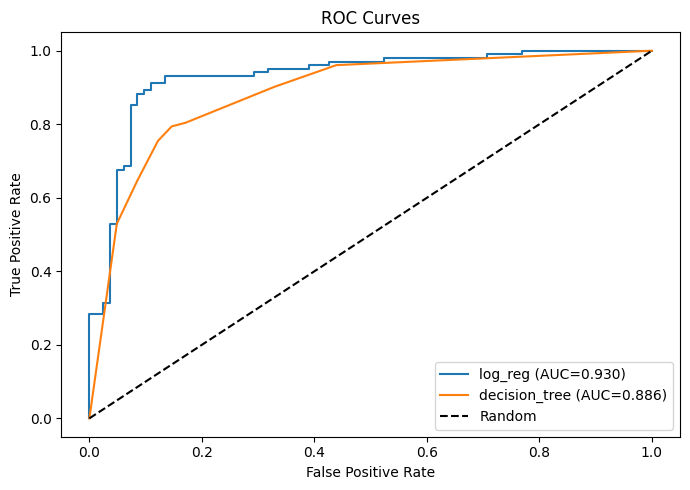

In [7]:
# Plot ROC curves
plot_roc_curves(roc_curves)

In [8]:
# Classification reports
for name, model in models.items():
    preds = model.predict(X_test)
    print(f"\n{name} classification report:\n", classification_report(y_test, preds))


log_reg classification report:
               precision    recall  f1-score   support

           0       0.91      0.85      0.88        82
           1       0.89      0.93      0.91       102

    accuracy                           0.90       184
   macro avg       0.90      0.89      0.89       184
weighted avg       0.90      0.90      0.90       184


decision_tree classification report:
               precision    recall  f1-score   support

           0       0.77      0.85      0.81        82
           1       0.87      0.79      0.83       102

    accuracy                           0.82       184
   macro avg       0.82      0.82      0.82       184
weighted avg       0.83      0.82      0.82       184



In [9]:
# Save artifacts
save_model(models["log_reg"], MODELS_DIR / "log_reg_pipeline.joblib")
save_model(models["decision_tree"], MODELS_DIR / "decision_tree_pipeline.joblib")

2026-01-02 10:00:23,871 [INFO] Saved model to ../models/log_reg_pipeline.joblib
2026-01-02 10:00:23,876 [INFO] Saved model to ../models/decision_tree_pipeline.joblib


### Quick Inference Smoke Test

In [10]:
payload = sample_payload()
pd.DataFrame([payload])

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
0,54,M,ASY,140,239,0,Normal,160,N,1.2,Flat


In [11]:
log_reg_loaded = joblib.load(MODELS_DIR / "log_reg_pipeline.joblib")
tree_loaded = joblib.load(MODELS_DIR / "decision_tree_pipeline.joblib")

for name, model in {"log_reg": log_reg_loaded, "decision_tree": tree_loaded}.items():
    proba = model.predict_proba(pd.DataFrame([payload]))[0, 1]
    pred = model.predict(pd.DataFrame([payload]))[0]
    print(f"{name}: pred={pred}, proba={proba:.3f}")

log_reg: pred=1, proba=0.791
decision_tree: pred=1, proba=0.929


## 4) Add Command-Line Entry/Runner

Provide a simple CLI-style function for local predictions using the saved models.

In [12]:
import argparse

def cli_predict(model_name: str, payload_path: Path):
    model_path = MODELS_DIR / f"{model_name}_pipeline.joblib"
    if not model_path.exists():
        raise FileNotFoundError(f"Model not found: {model_path}")
    model = joblib.load(model_path)
    with open(payload_path) as f:
        payload = json.load(f)
    df = pd.DataFrame([payload])
    proba = model.predict_proba(df)[0, 1]
    pred = model.predict(df)[0]
    print(json.dumps({"prediction": int(pred), "probability": proba}, indent=2))


def main():
    parser = argparse.ArgumentParser(description="Predict heart disease from JSON payload")
    parser.add_argument("model", choices=["log_reg", "decision_tree"], help="Model to use")
    parser.add_argument("payload", type=str, help="Path to JSON payload file")
    args = parser.parse_args()
    cli_predict(args.model, Path(args.payload))

# Uncomment below to use within notebook
# if False:
#     main()

## 5) Integrate Logging and Error Handling

Already configured logging at INFO level; functions raise informative errors for missing files or creds.

In [13]:
try:
    _ = pd.DataFrame([sample_payload()])
    LOGGER.info("Sample payload validated")
except Exception as e:
    LOGGER.error("Validation failed: %s", e)
    raise

2026-01-02 10:00:29,251 [INFO] Sample payload validated


## 6) Write and Run Unit Tests

Lightweight assertions to ensure model files exist and inference works on the sample payload.

In [14]:
assert (MODELS_DIR / "log_reg_pipeline.joblib").exists(), "LogReg model missing"
assert (MODELS_DIR / "decision_tree_pipeline.joblib").exists(), "Decision Tree model missing"

for name in ["log_reg", "decision_tree"]:
    model = joblib.load(MODELS_DIR / f"{name}_pipeline.joblib")
    df = pd.DataFrame([sample_payload()])
    proba = model.predict_proba(df)[0, 1]
    pred = model.predict(df)[0]
    assert 0 <= proba <= 1
    assert pred in [0, 1]
print("Smoke tests passed")

Smoke tests passed


## 7) Basic Performance Check (Optional)

Quick timing of a single prediction.

In [15]:
import timeit

log_reg_loaded = joblib.load(MODELS_DIR / "log_reg_pipeline.joblib")

time_ms = timeit.timeit(
    "log_reg_loaded.predict_proba(df)[0, 1]",
    number=50,
    globals={"log_reg_loaded": log_reg_loaded, "df": pd.DataFrame([sample_payload()])},
)
print(f"Avg predict_proba over 50 runs: {time_ms/50*1000:.3f} ms")

Avg predict_proba over 50 runs: 3.309 ms
